In this example:

Observable is: 2II−3XX+2YY−4ZZ

Eigenvalues are -7, 3, 5, 7

Eigenstates are the bell states

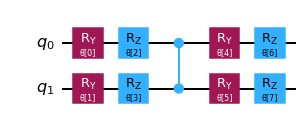

In [1]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

ansatz.decompose().draw('mpl')

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable_2 = SparsePauliOp.from_list([("II", 2), ("XX", -3), ("YY", 2), ("ZZ", -4)])

In [3]:
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler, realbackend,backend):

    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        if realbackend == 1:
            pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
            fidelity_circuit = pm.run(fidelity_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

In [4]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian, realbackend, backend):
    
    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler, realbackend, backend)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

In [6]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator

sampler = StatevectorSampler(default_shots=4092)
estimator = StatevectorEstimator()

In [7]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

k = 4
betas = [50, 60, 40]
x0 = np.ones(8)

In [8]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable_2, realbackend, None), method="COBYLA", options={'maxiter': 200, 'tol':0.000001})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.999999999994419
       x: [ 1.571e+00  1.571e+00  1.993e+00  2.163e+00  1.020e+00
            1.214e+00  1.694e+00  2.788e+00]
    nfev: 194
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 3.3966621788962974
       x: [ 1.175e+00  1.024e+00  1.226e+00  1.484e+00  1.197e+00
            1.474e+00  8.152e-01  9.874e-01]
    nfev: 134
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5.68524911308297
       x: [ 2.807e+00  2.623e+00 -3.693e-01  3.938e-01  2.381e+00
            2.174e-02  1.291e+00  1.899e+00]
    nfev: 123
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 7.195152621095726
       x: [ 3.266e+00  2.455e+00  2.033e+00 -4.605e-01  4.086e-01
            2.737e+00  2.264e+00  2.971e+00]
    nfev: 115
   maxcv: 0.0


In [9]:
eigenvalues

[-6.999999999994419, 3.3966621788962974, 5.68524911308297, 7.195152621095726]

We observe, that the results are close to the expected ones.

In [10]:
solution_eigenvalues = [-7, 3, 5, 7]

for index, experimental_eigenvalue in enumerate(eigenvalues):
    solution_eigenvalue = solution_eigenvalues[index]
    
    print(
        f"Percent error: {abs((experimental_eigenvalue - solution_eigenvalue)/solution_eigenvalue):.2e}"
    )

Percent error: 7.97e-13
Percent error: 1.32e-01
Percent error: 1.37e-01
Percent error: 2.79e-02


Beta is supposed to be bigger than the difference between the eigenvalues. let us observe what happens when that condition is not satisfied

In [11]:
from qiskit.quantum_info import SparsePauliOp

k = 4
betas = np.ones(3)
x0 = np.zeros(8)

In [12]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable_2, realbackend, None), method="COBYLA", options = {'tol' : 0.01, 'maxiter': 200})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -3.942775915547547
       x: [ 6.783e-01 -7.137e-01  2.081e-02 -1.683e-02 -4.348e-01
            4.970e-01  2.792e-02  2.478e-02]
    nfev: 200
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0515146272492557
       x: [-1.344e-02  3.352e-03 -5.588e-04 -2.710e-01  4.204e-03
           -1.794e-03  1.005e+00  3.534e-02]
    nfev: 46
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.056423687595772654
       x: [ 9.708e-04 -6.174e-03  1.002e+00  1.087e-03 -6.099e-03
           -7.957e-04 -4.347e-03  4.550e-04]
    nfev: 41
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.9549322225150054
       x: [ 2.010e-04  8.588e-03  1.000e+00  2.536e-01 -9.053e-04
           -3.709e-04  1.003e+00  1.735e-03]
    nfev: 42
   maxcv: 0.0


In [13]:
solution_eigenvalues = [-7, 3, 5, 7]

for index, experimental_eigenvalue in enumerate(eigenvalues):
    solution_eigenvalue = solution_eigenvalues[index]
    
    print(
        f"Percent error: {abs((experimental_eigenvalue - solution_eigenvalue)/solution_eigenvalue):.2e}"
    )

Percent error: 4.37e-01
Percent error: 1.35e+00
Percent error: 1.01e+00
Percent error: 8.64e-01


In [14]:
eigenvalues

[-3.942775915547547,
 -1.0515146272492557,
 -0.056423687595772654,
 0.9549322225150054]

Thus we got wrong output

Running on real hardware:

In [15]:
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, Session, Options, QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)

In [16]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable_2.apply_layout(layout = isa_ansatz.layout)

In [ ]:
k = 2
betas = [30, 50, 80]
x0 = np.zeros(8)

real_prev_states = []
real_prev_opt_parameters = []
real_eigenvalues = []

realbackend = 1

with Session(backend=backend) as session:

    estimator = Estimator(session)
    estimator.options.resilience_level = 1
    estimator.options.default_shots = 4096
    sampler = Sampler(session)
    
    for step in range(1, k + 1):
    
        if step > 1:
            real_prev_states.append(isa_ansatz.assign_parameters(prev_opt_parameters))
    
        result = minimize(cost_func_vqd, x0, args=(isa_ansatz, real_prev_states, step, betas, estimator, sampler, isa_observable, realbackend, backend), method="COBYLA", options = {'maxiter':200})
        print(result)

        real_prev_opt_parameters = result.x
        real_eigenvalues.append(result.fun)

session.close()
print(real_eigenvalues)